In [1]:
import numpy as np
import pandas as pd
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
from jetstream_hugo.hotspells import *

import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

ERROR 1: PROJ: proj_create_from_database: Open of /storage/homefs/hb22g102/mambaforge/envs/env11/share/proj failed


In [1]:
exp = MultiVarExperiment("ERA5", "plev", ["u", "v", "s"], "6H", (1940, 2022), None, -80, 30, 20, 80, [200, 250, 300])
all_jets, where_are_jets, all_jets_one_array, all_jets_over_time, flags = exp.track_jets()
props_as_ds_uncat = exp.props_as_ds(False)
props_as_ds = exp.props_as_ds(True)
props_as_ds["nao"] = get_nao(props_as_ds)
exp_T = Experiment(
    "ERA5", "surf", "t", "6H", (1959, 2022), "JJA", -30, 40, 30, 75, "all", 'hourofyear', {'hourofyear': ('win', 60)}, None,
)
da_T = exp_T.da
da_cee = exp_T.select_heat_wave_cluster(10, 6)
JA_mask = np.isin(da_cee.time.dt.month, [7, 8])
heat_waves_ts, heat_waves, hs_da = heat_waves_from_t(da_cee, fill_holes=True, output_type="both")
props_as_ds_masked = mask_from_t(da_cee, props_as_ds, q=0.8, fill_holes=True, time_before=pd.Timedelta(4, 'D'))
time_mask = (props_as_ds.time.dt.season=="JJA") & (props_as_ds.time.dt.year>=1959)
da_jet_pos = jet_position_as_da(ds["s"], props_as_ds, props_as_ds_uncat, all_jets, exp.path).sel(time=time_mask)
ds_late = flatten_by(ds.sel(time=time_mask), "s")
subset = ["mean_lon", "mean_lat", "mean_lev", "width", "persistence", "int"]
props_as_np = props_as_ds[subset].sel(time=time_mask).to_dataarray().values
props_as_np = props_as_np.transpose(1, 0, 2).reshape(props_as_np.shape[1], props_as_np.shape[0] * props_as_np.shape[2]) 
da_jet_pos = jet_position_as_da(exp.ds["s"], props_as_ds, props_as_ds_uncat, all_jets, exp.path).sel(time=time_mask)

NameError: name 'MultiVarExperiment' is not defined

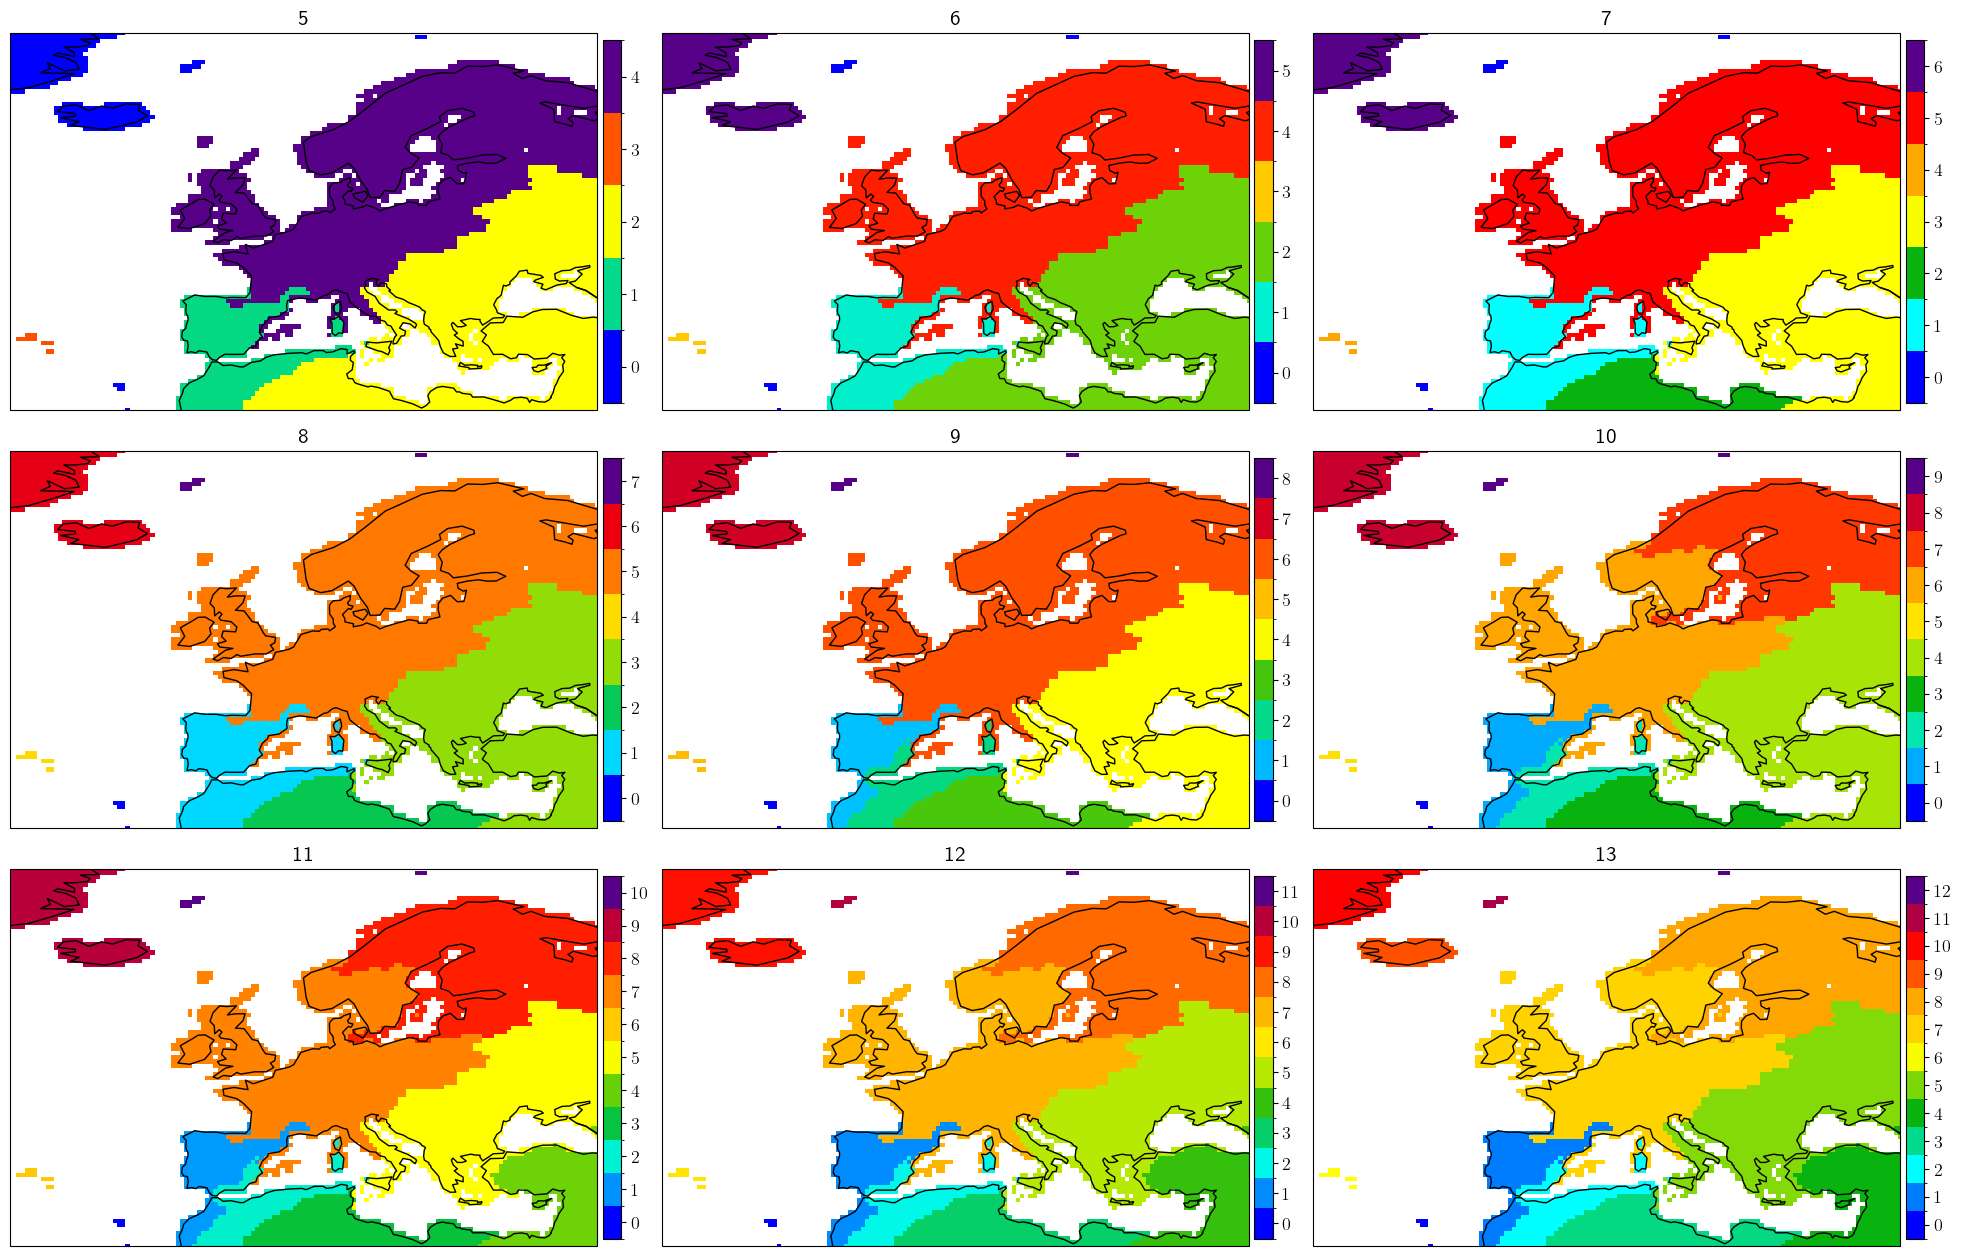

In [6]:
clu = Clusterplot(3, 3, exp_T.region)
Z = exp_T.heat_wave_linkage()
cmap = colormaps.BlAqGrYeOrReVi200
mask = get_land_mask()
lon, lat = da_T.lon.values, da_T.lat.values
mask = mask.sel(lon=lon, lat=lat)
stack_dims = {'lat_lon': ('lat', 'lon')}
mask_flat = mask.stack(stack_dims)
for i, n_clu in enumerate(range(5, 14)):
    clusters = cut_tree(Z, n_clusters=n_clu)[:, 0]
    clusters_da = np.zeros(mask_flat.shape, dtype=float)
    clusters_da[:] = np.nan
    clusters_da = mask_flat.copy(data=clusters_da)
    clusters_da[mask_flat] = clusters
    unique_clusters = np.unique(clusters)
    norm = BoundaryNorm(np.concatenate([[-1], unique_clusters]) + 0.5, cmap.N)
    every = n_clu // 20 + 1
    clusters_da.unstack().plot(
        ax=clu.axes[i],
        cmap=cmap,
        add_colorbar=False,
        add_labels=False
    )
    clu.axes[i].set_title(n_clu)
    im = ScalarMappable(cmap=cmap, norm=norm)
    clu.fig.colorbar(im, ax=clu.axes[i], ticks=np.arange(0, n_clu, every), shrink=0.92, pad=0.01)

# Jet index around heat waves

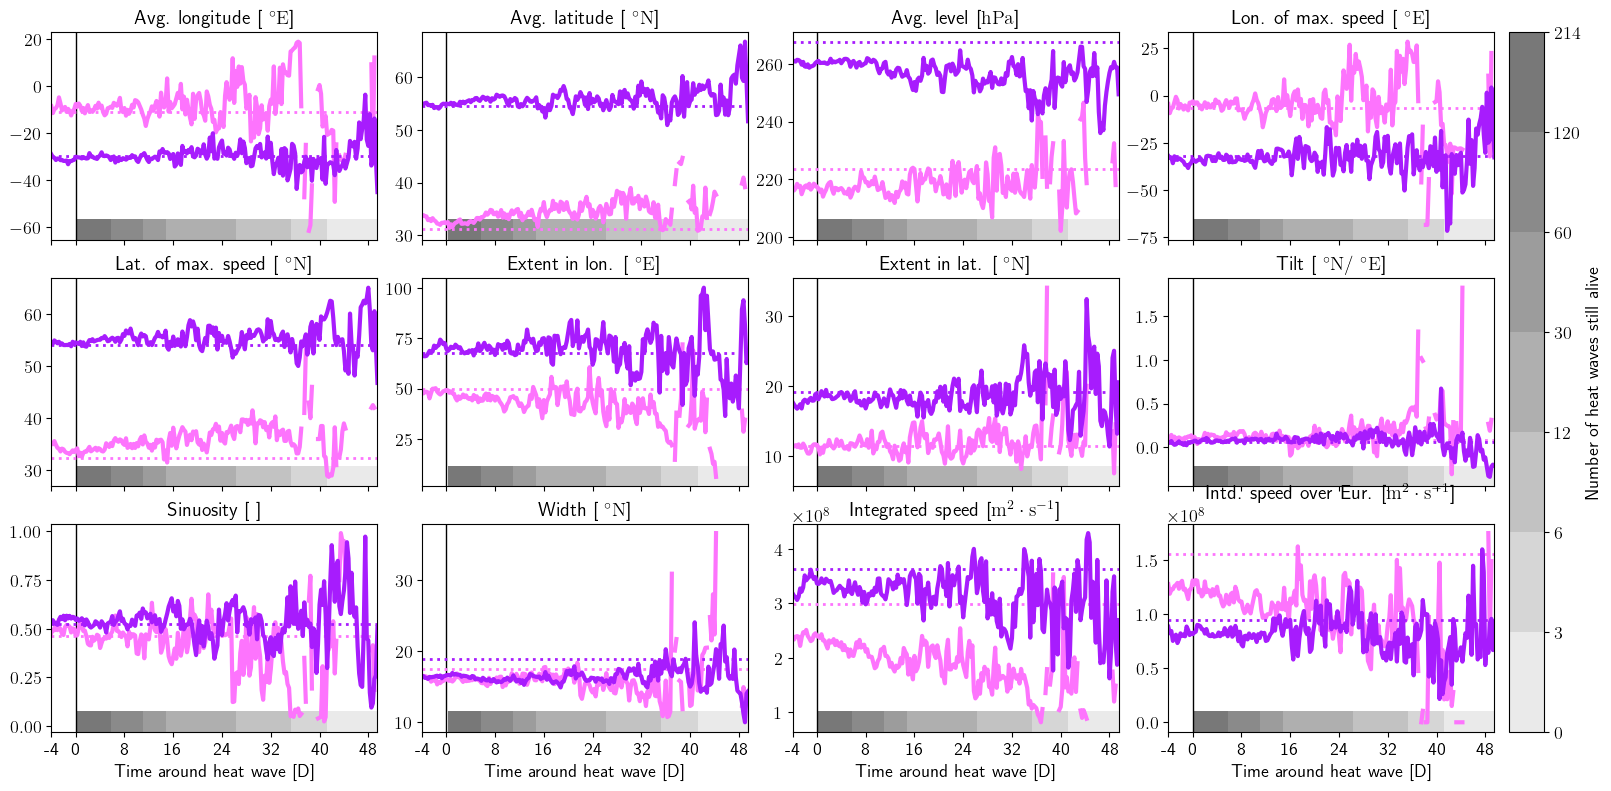

In [12]:
data_vars = ["mean_lon", "mean_lat", "mean_lev", "Lon", "Lat", "lon_ext", "lat_ext", "tilt", "sinuosity", "width", "int", "int_over_europe"]
fig, axes = plt.subplots(
    len(data_vars) // 4,
    4,
    figsize=(16, len(data_vars) // 4 * 2.6),
    constrained_layout=True,
    sharex='all'
)
months = np.unique(props_as_ds.time.dt.month.values)
months = [str(months[0]).zfill(2), str(min(12, months[-1] + 1)).zfill(2)]
lengths = heat_waves[:, 1] - heat_waves[:, 0]
longest_hotspell = np.argmax(lengths)
time_around_beg = heat_waves_ts[longest_hotspell] - heat_waves[longest_hotspell, 0]
time_around_beg = time_around_beg.values
dt = (props_as_ds.time.values[1] - props_as_ds.time.values[0]).astype('timedelta64[h]')
colors = COLORS[2:0:-1]
n_hotspell = 1
x = props_as_ds_masked.time_around_beg.values.astype('timedelta64[h]')
for varname, ax in zip(data_vars, axes.ravel()):
    for j, jet in enumerate(props_as_ds_masked.jet.values):
        this_da = props_as_ds_masked[varname].loc[..., jet]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            mean = this_da.mean(dim='heat_wave').values
        ax.plot(x, mean, color=colors[j], lw=3, ls='solid')
        mean_all = props_as_ds[varname].sel(jet=jet).mean(dim='time').values
        ax.plot(x, [mean_all] * len(this_da.time_around_beg), color=colors[j], lw=2, ls='dotted')
from matplotlib.lines import Line2D

custom_lines = [
    Line2D([0], [0], color='black', lw=2, linestyle='solid', alpha=0.6),
    Line2D([0], [0], color='black', lw=3, linestyle='solid'),
    Line2D([0], [0], color='black', lw=2, linestyle='dotted'),
    Line2D([0], [0], color=colors[0], lw=3),
    Line2D([0], [0], color=colors[1], lw=3),
]
handles = [
    f'{props_as_ds_masked.absolute_time[n_hotspell, 0].dt.year.values} event', f'All heat waves', f'Mean of index',
    'Subtropical jet',
    'Polar jet'
]
positive_mask = x.astype(int) > 0
alive_hotspells = (~this_da[:, positive_mask].isnull()).sum(dim='heat_wave').values
cmap = colormaps.cet_l_grey_r
cmap = LinearSegmentedColormap.from_list(
    'mod_grey', 
    cmap(np.linspace(0.1, 0.73, 200)), N=200
)
norm = BoundaryNorm([0, 3, 6, 12, 30, 60, 120, alive_hotspells.max()], cmap.N)
indices = [0] + np.arange(16, len(x), 32).tolist()
ticks = x[indices].astype(int)
xlim = np.amin(x.astype(float)), np.amax(x.astype(float))
ticklabels = x.astype('timedelta64[D]').astype(int)[indices]
for varname, ax in zip(data_vars, axes.ravel()):
    ax.set_title(f'{PRETTIER_VARNAME[varname]} [{UNITS[varname]}]', fontsize=14)
    ylim = np.asarray(ax.get_ylim())
    ybounds = ylim[[0, 0]] + np.asarray([0, 0.1 * (ylim[1] - ylim[0])])
    im = ax.pcolormesh(
        x.astype(float)[positive_mask], ybounds, alive_hotspells[None, :-1], zorder=-10, norm=norm,
        cmap=cmap, alpha=0.7
    )
    ax.set_xlim(xlim)
    ax.set_xticks(ticks, ticklabels, ha='center')
    ax.vlines(0, *ylim, color='black', lw=1, ls='solid', zorder=-10)
    ax.set_ylim(ylim)
cbar = fig.colorbar(im, ax=axes, pad=0.01)
_ = cbar.ax.set_ylabel('Number of heat waves still alive')
for ax in axes[-1, :]:
    ax.set_xlabel('Time around heat wave [D]')
plt.savefig(f'{FIGURES}/jet_props_misc/jet_props_vs_hotspell.png', dpi=300)

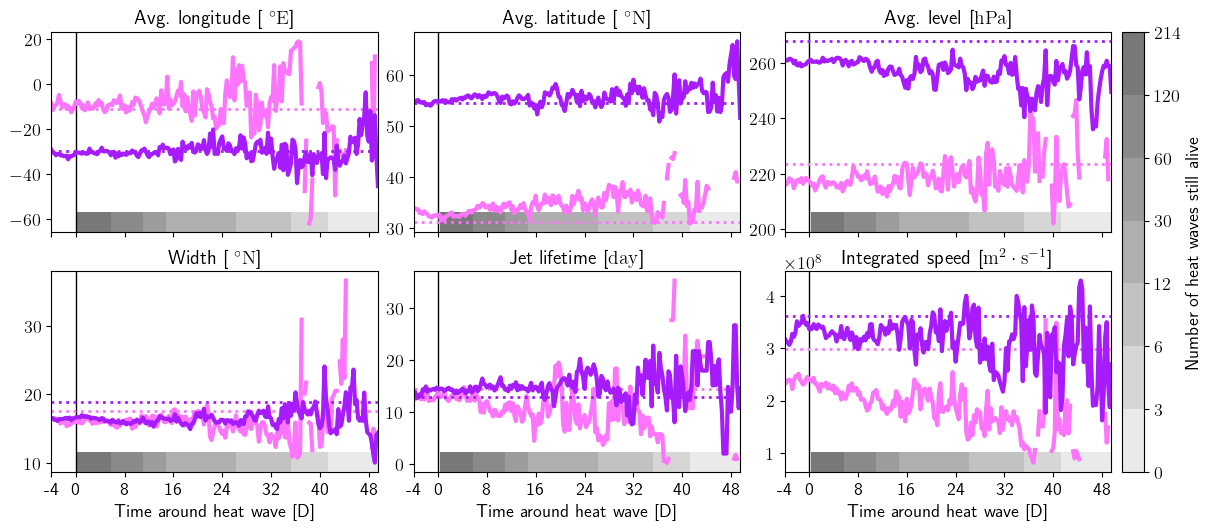

In [13]:
data_vars = ["mean_lon", "mean_lat", "mean_lev", "width", "persistence", "int"]
fig, axes = plt.subplots(
    len(data_vars) // 3,
    3,
    figsize=(12, len(data_vars) // 3 * 2.6),
    constrained_layout=True,
    sharex='all'
)
months = np.unique(props_as_ds.time.dt.month.values)
months = [str(months[0]).zfill(2), str(min(12, months[-1] + 1)).zfill(2)]
lengths = heat_waves[:, 1] - heat_waves[:, 0]
longest_hotspell = np.argmax(lengths)
time_around_beg = heat_waves_ts[longest_hotspell] - heat_waves[longest_hotspell, 0]
time_around_beg = time_around_beg.values
dt = (props_as_ds.time.values[1] - props_as_ds.time.values[0]).astype('timedelta64[h]')
colors = COLORS[2:0:-1]
n_hotspell = 1
x = props_as_ds_masked.time_around_beg.values.astype('timedelta64[h]')
for varname, ax in zip(data_vars, axes.ravel()):
    for j, jet in enumerate(props_as_ds_masked.jet.values):
        this_da = props_as_ds_masked[varname].loc[..., jet]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            mean = this_da.mean(dim='heat_wave').values
        ax.plot(x, mean, color=colors[j], lw=3, ls='solid')
        mean_all = props_as_ds[varname].sel(jet=jet).mean(dim='time').values
        ax.plot(x, [mean_all] * len(this_da.time_around_beg), color=colors[j], lw=2, ls='dotted')
from matplotlib.lines import Line2D

custom_lines = [
    Line2D([0], [0], color='black', lw=2, linestyle='solid', alpha=0.6),
    Line2D([0], [0], color='black', lw=3, linestyle='solid'),
    Line2D([0], [0], color='black', lw=2, linestyle='dotted'),
    Line2D([0], [0], color=colors[0], lw=3),
    Line2D([0], [0], color=colors[1], lw=3),
]
handles = [
    f'{props_as_ds_masked.absolute_time[n_hotspell, 0].dt.year.values} event', f'All heat waves', f'Mean of index',
    'Subtropical jet',
    'Polar jet'
]
positive_mask = x.astype(int) > 0
alive_hotspells = (~this_da[:, positive_mask].isnull()).sum(dim='heat_wave').values
cmap = colormaps.cet_l_grey_r
cmap = LinearSegmentedColormap.from_list(
    'mod_grey', 
    cmap(np.linspace(0.1, 0.73, 200)), N=200
)
norm = BoundaryNorm([0, 3, 6, 12, 30, 60, 120, alive_hotspells.max()], cmap.N)
indices = [0] + np.arange(16, len(x), 32).tolist()
ticks = x[indices].astype(int)
xlim = np.amin(x.astype(float)), np.amax(x.astype(float))
ticklabels = x.astype('timedelta64[D]').astype(int)[indices]
for varname, ax in zip(data_vars, axes.ravel()):
    ax.set_title(f'{PRETTIER_VARNAME[varname]} [{UNITS[varname]}]', fontsize=14)
    ylim = np.asarray(ax.get_ylim())
    ybounds = ylim[[0, 0]] + np.asarray([0, 0.1 * (ylim[1] - ylim[0])])
    im = ax.pcolormesh(
        x.astype(float)[positive_mask], ybounds, alive_hotspells[None, :-1], zorder=-10, norm=norm,
        cmap=cmap, alpha=0.7
    )
    ax.set_xlim(xlim)
    ax.set_xticks(ticks, ticklabels, ha='center')
    ax.vlines(0, *ylim, color='black', lw=1, ls='solid', zorder=-10)
    ax.set_ylim(ylim)
cbar = fig.colorbar(im, ax=axes, pad=0.01)
_ = cbar.ax.set_ylabel('Number of heat waves still alive')
for ax in axes[-1, :]:
    ax.set_xlabel('Time around heat wave [D]')
plt.savefig(f'{FIGURES}/jet_props_misc/jet_props_vs_hotspell_subset.png', dpi=300)

# Jet position around heat waves

In [11]:
summer_post_1959 = (props_as_ds.time.dt.season == "JJA") & (props_as_ds.time.dt.year >= 1959)

In [12]:
da_jet_pos = jet_position_as_da(exp.ds["s"], props_as_ds, props_as_ds_uncat, all_jets, exp.path).sel(time=summer_post_1959)

In [15]:
da_jet_pos_masked = mask_from_t(da_cee, da_jet_pos, q=0.8, fill_holes=True, time_before=pd.Timedelta(4, 'D'))

/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/hotspells.py:35: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  mask = heat_waves.astype('datetime64[h]').values
/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/hotspells.py:50: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArr

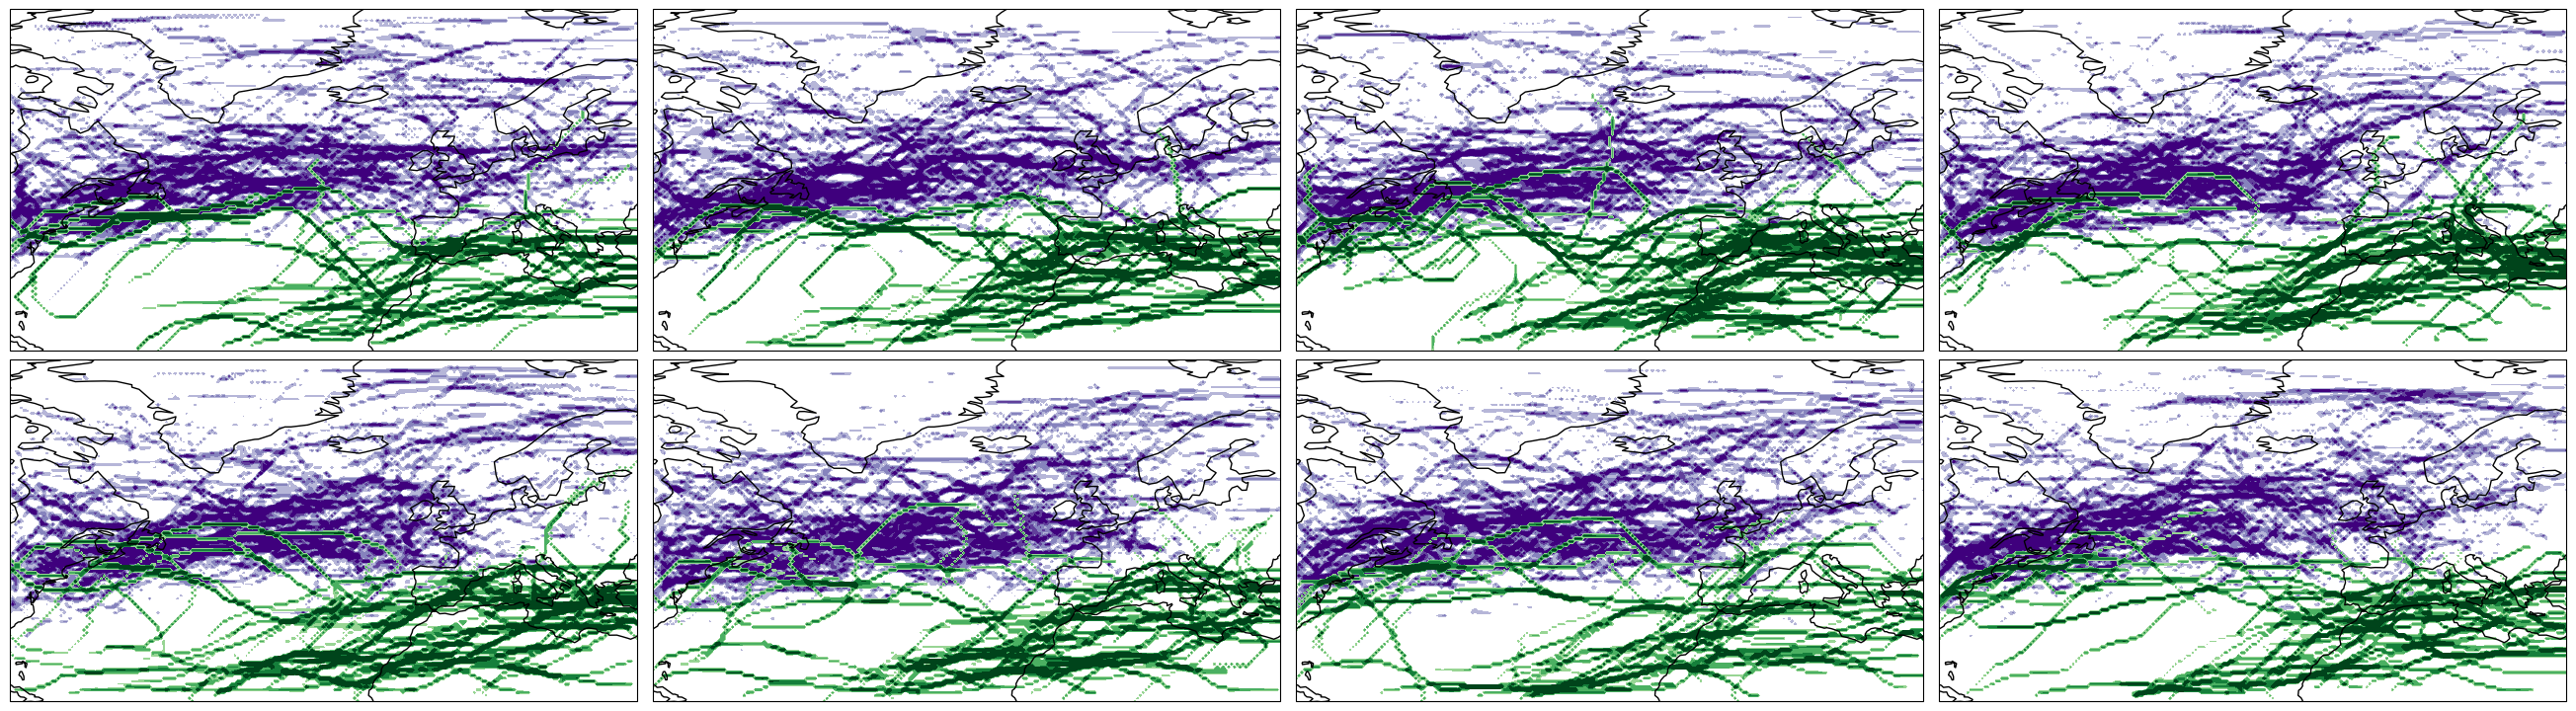

In [26]:
timesteps = np.arange(0, 32, 4)
this_da = da_jet_pos_masked.mean(dim="heat_wave")
to_plot_subtropical = [this_da.isel(time_around_beg=tag, jet=0) for tag in timesteps]
to_plot_polar = [this_da.isel(time_around_beg=tag, jet=1) for tag in timesteps]
clu = Clusterplot(len(timesteps) // 4, 4, region=get_region(this_da))
_ = clu.add_contourf(to_plot_polar, cmap='Purples', transparify=2, draw_cbar=False, q=0.9)
_ = clu.add_contourf(to_plot_subtropical, cmap='Greens', transparify=2, draw_cbar=False, q=0.9)
# plt.savefig('/storage/homefs/hb22g102/persistent-extremes-era5/Figures/jet_index_extremes_composites/jet_index_vs_jet_pos.png')

In [28]:
ds_masked = mask_from_t(da_cee, exp.ds.sel(time=summer_post_1959), q=0.8, fill_holes=True, time_before=pd.Timedelta(4, 'D'))

/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/hotspells.py:35: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  mask = heat_waves.astype('datetime64[h]').values
/storage/homefs/hb22g102/jetstream_hugo/src/jetstream_hugo/hotspells.py:50: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArr

In [ ]:
timesteps = np.arange(0, 32, 4)
this_da = da_jet_pos_masked.mean(dim="heat_wave")
to_plot_subtropical = [this_da.isel(time_around_beg=tag, jet=0) for tag in timesteps]
to_plot_polar = [this_da.isel(time_around_beg=tag, jet=1) for tag in timesteps]
clu = Clusterplot(len(timesteps) // 4, 4, region=get_region(this_da))
_ = clu.add_contourf(to_plot_polar, cmap='Purples', transparify=2, draw_cbar=False, q=0.9)
_ = clu.add_contourf(to_plot_subtropical, cmap='Greens', transparify=2, draw_cbar=False, q=0.9)
# plt.savefig('/storage/homefs/hb22g102/persistent-extremes-era5/Figures/jet_index_extremes_composites/jet_index_vs_jet_pos.png')